# This notebook includes some examples of plotting and computing statistics that are described in the workflow paper

## Section 1: Computing statistics
The processes in this section are similar to notebook ensemble(mean)_TempPrecip(change)_more_options. See there for detailed description.

## Section 2: North African monsoon (NAF) expansion in the midHolocene and lig127k than the piControl
## Section 3: Changes in NAF (midHolocene - piControl)

In [1]:
# import packages
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
import matplotlib.colors as colors
from matplotlib import gridspec 
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import tarfile
import os
from scipy.interpolate import interp1d
from scipy import interpolate

In [2]:
# CMIP6 colours

# Option 1: according to experimental name and PMIP generation
# each file has 7 columns:
#  "model": model names
#  "ncl_<R,G,B>": R, G, B values (0-255) used in ncl scripts
#  "ipcc_<r,g,b>": R, G, B values (0-1) used in notebooks/python scripts

def information(p,expt):
    f = pd.read_csv('%s_%s_modellist.csv'%(p,expt),skipinitialspace=True,header=0)
    m = f['model']
    r = f['ipcc_r']
    g = f['ipcc_g']
    b = f['ipcc_b']
    return m,r,g,b

# Option 2: all colors
# header: model name
#  "ncl_<R,G,B>": R, G, B values (0-255) used in ncl scripts
#  "py_<R,G,B>": R, G, B values (0-1) used in notebooks/python scripts
# row order: ncl_R, ncl_G, ncl_B, py_R, py_G, py_B

color_information = pd.read_csv('color_information.csv',skipinitialspace=True,header=0)
def model_color(model,kind): # kind ncl or py
    if kind == 'ncl':
        r = color_information[model][0]
        g = color_information[model][1]
        b = color_information[model][2]
    if kind == 'py':
        r = color_information[model][3]
        g = color_information[model][4]
        b = color_information[model][5]
    color = [r,g,b]
    return color
   

# Section 1

In [3]:
'''Define pimp generations and model names'''
# This cell lists the models involved in PMIP4 and PMIP3
pmip = {}
pmip['PMIP4'] = ['ACCESS-ESM1-5',
                 'AWI-ESM-1-1-LR',
                 'AWI-ESM-2-1-LR',
                 'CESM2',
                 'CNRM-CM6-1',
                 'EC-Earth3-LR',
                 'FGOALS-f3-L',
                 'FGOALS-g3',
                 'GISS-E2-1-G',
                 'HadGEM3-GC31-LL',
                 'INM-CM4-8',
                 'IPSL-CM6A-LR',
                 'MIROC-ES2L',
                 'MPI-ESM1-2-LR',
                 'MRI-ESM2-0',
                 'NESM3',
                 'NorESM1-F',
                 'NorESM2-LM',
                 'UofT-CCSM-4']
pmip['PMIP3'] = ['bcc-csm1-1',
                 'CCSM4',
                 'CNRM-CM5',
                 'CSIRO-Mk3L-1-2',
                 'CSIRO-Mk3-6-0',
                 'EC-EARTH-2-2',
                 'FGOALS-g2',
                 'FGOALS-s2',
                 'GISS-E2-R',
                 'HadGEM2-CC',
                 'HadGEM2-ES',
                 'IPSL-CM5A-LR',
                 'MIROC-ESM',
                 'MPI-ESM-P',
                 'MRI-CGCM3']
               
               
#expand out the provided data if there isn't already something there
if not os.path.exists('../data_netcdf/piControl'):
   tar = tarfile.open("../data_netcdf/PMIP4_tas_pr_data.tar.gz")
   tar.extractall(path='../data_netcdf/')
               

## This part define the functions to find files fitting variable and experiment requirements.

In [4]:
#No change needs here
#This cell defines the functions to find variables, models and experiments


#This function will get all available experiment names
def experimentlist():
    exps=[]
    file_path = "../data_netcdf/"
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for d in dirnames:
            exps.append(d)
    return exps

#This function will get all available model names in the experiment 
def modellist(experiment_name):
    models=[]
    file_path = "../data_netcdf/%s" %(experiment_name)
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for f in filenames:
            mname=f.split("_")[0]
            models.append(mname)
    return models

#This function will get all available filenames in the experiment 
def filenamelist(experiment_name):
    filenames=[]
    file_path = "../data_netcdf/%s" %(experiment_name)
    for dirpaths, dirnames, files in os.walk(file_path):
        for f in files:
            ff='../data_netcdf/%s/%s'%(experiment_name,f)
            filenames.append(ff)
    return filenames

#This function will identify models in the ensemble
def identify_ensemble_members(variable_name,experiment_name):
    datadir="../data_netcdf/%s" %(experiment_name)
    ensemble_members = [] #create an empty list
    with os.scandir(datadir) as entries:
        for entry in entries:
            this_file=xr.open_dataset(entry,decode_times=False)
            if variable_name in list(this_file.keys()):
                ensemble_members.append(datadir+"/"+entry.name)
            this_file.close()
    return ensemble_members

#This function will list extract model name
def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

#This function will collect member models which have the variable in the experiment
def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict
    


# Section 2: Arctic sea ice area

In [18]:
def calculation_ensemble_change_1D(pmip_v,experiment_name,variable_name):
    model_list = []
    DATA = {}
    DATA_A = {}
    DATA_B = {}
    A_dict = ensemble_members_dict(variable_name,experiment_name)
    B_dict = ensemble_members_dict(variable_name,'piControl')
    for gcm in A_dict:
        if gcm in B_dict:
                if gcm in pmip[pmip_v]:
                    model_list.append(gcm)              
                    expt_a_file = xr.open_dataset(A_dict.get(gcm),decode_times=False)
                    expt_a = expt_a_file[variable_name]
                    expt_b_file = xr.open_dataset(B_dict.get(gcm),decode_times=False)
                    expt_b = expt_b_file[variable_name]
                    diff = expt_a - expt_b                          
                    DATA[gcm] = list(np.array(diff))
                    DATA_A[gcm] = list (np.array(expt_a))
                    DATA_B[gcm] = list (np.array(expt_b))
    #calculating average and std
    dataset = np.zeros((len(model_list),12))
    dataseta = np.zeros((len(model_list),12))
    datasetb = np.zeros((len(model_list),12))
    for i,m in enumerate(model_list):
        dataset[i] = DATA[m]
        dataseta[i] = DATA_A[m]
        datasetb[i] = DATA_B[m]
    DATA['average'] = list(np.average(dataset, axis=0))
    DATA['std'] = list(np.std(dataset, axis=0))
    DATA_A['average'] = list(np.average(dataseta, axis=0))
    DATA_A['std'] = list(np.std(dataseta, axis=0))
    DATA_B['average'] = list(np.average(datasetb, axis=0))
    DATA_B['std'] = list(np.std(datasetb, axis=0))
    return model_list,DATA,DATA_A,DATA_B
    



In [19]:
nh_model,nh_ice_change, nh_ice_mh,nh_ice_pi= calculation_ensemble_change_1D('PMIP4','midHolocene-cal-adj','sic_nh_area_climo')


In [20]:
# Change the sea ice unit from 10^12 m2 to 10^6 km2
nh_ice_change = nh_ice_change 
nh_ice_mh = nh_ice_mh 
nh_ice_pi = nh_ice_pi 

In [21]:
# Observations
NOAA_n=[13.7,14.6,14.7,13.9,12.4,10.4,7.7,5.6,5.1,7.1,9.9,12.1]


(array([-250., -200., -150., -100.,  -50.,    0.,   50.,  100.,  150.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

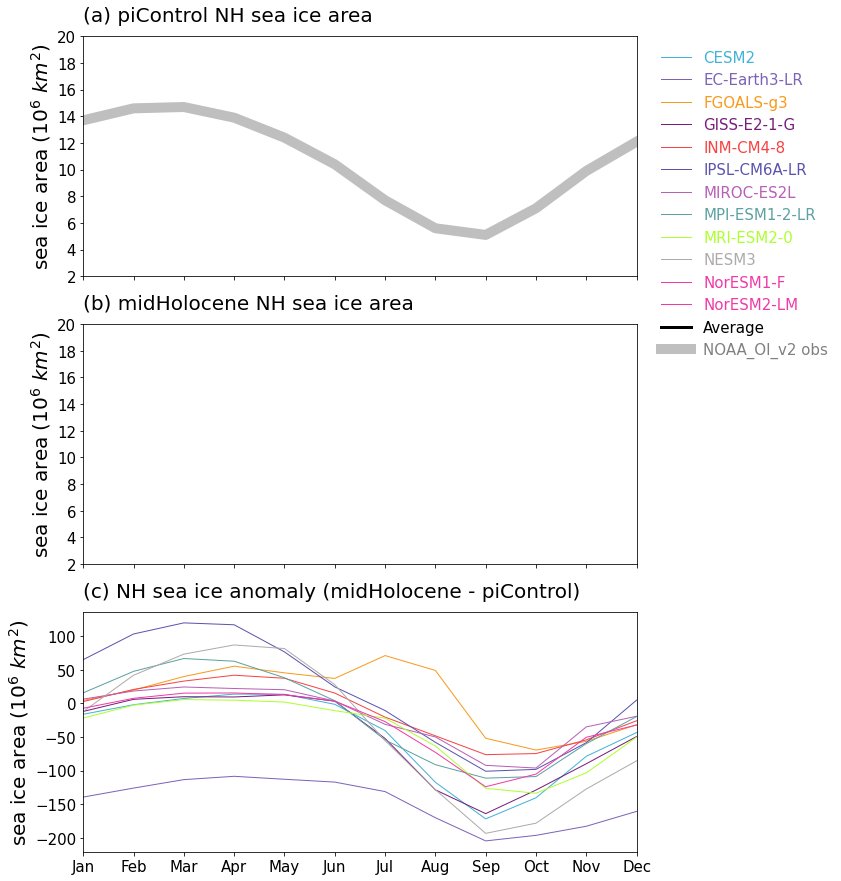

In [36]:
def subplotting1(title,data,modellist): 
    month = [1,2,3,4,5,6,7,8,9,10,11,12]
    plt.title(title,fontsize=20,loc='left',pad=15)
    plt.xlim([1,12])
    for m in pmip['PMIP4']:
        if m in modellist:
            plt.plot(month,data[m],color=model_color(m,'py'),lw=1,label=m)
    plt.plot(month,data['average'],color='k',lw=3,label='Average')
    yylabel='sea ice area ($10^{6}$ ${km^2}$)'
    plt.ylabel(yylabel,fontsize=20)
    
month=[1,2,3,4,5,6,7,8,9,10,11,12]
month1=['','','','','','','','','','','','']
month2=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# plotting
plt.figure(figsize=(12,15))
gs = gridspec.GridSpec(3,2,height_ratios=[1,1,1],width_ratios=[10,1])
plt.subplot(gs[0])
subplotting1('(a) piControl NH sea ice area',nh_ice_pi,nh_model)
plt.ylim([2,20])
plt.xticks(month,month1,fontsize=15)
plt.yticks(fontsize=15)
plt.plot(month,NOAA_n,color='grey',alpha=0.5,lw=10,label='NOAA_OI_v2 obs')
leg=plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left',edgecolor='None',facecolor='None', borderaxespad=0.5,fontsize=15)
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())


plt.subplot(gs[2])
subplotting1('(b) midHolocene NH sea ice area',nh_ice_mh,nh_model)
plt.ylim([2,20])
plt.xticks(month,month1,fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(gs[4])
subplotting1('(c) NH sea ice anomaly (midHolocene - piControl)',nh_ice_change,nh_model)
plt.xticks(month,month2,fontsize=15)
plt.yticks(fontsize=15)
#xxlabel='Month' 
#plt.xlabel(xxlabel,fontsize=15)


# Section 3: NAF expansion


In [5]:
# This function outputs lat. averaged monsoon summer rain rate over northern Africa
def calculation_ensemble_naf_expansion(pmip_v,experiment_name): 
    variable_name='monsoon_summer_rainrate'
    model_list = []
    DATA = {}
    lat=np.arange(-89.5,90,1)
    LL=lat[90:120]
    DATA['lat'] = LL
    var_dict = ensemble_members_dict(variable_name,experiment_name)
    grid_1x1 = xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-179.5, 180, 1.0))})
    for gcm in var_dict:
            if gcm in pmip[pmip_v]:
                model_list.append(gcm)              
                expt_file = xr.open_dataset(var_dict.get(gcm),decode_times=False)
                var = expt_file[variable_name]
                this_regridder = xe.Regridder(expt_file,grid_1x1,'bilinear', reuse_weights=False,periodic=True) 
                var_1x1 = this_regridder(var)               
                naf_pr = var_1x1[90:120,160:210]
                ave = list(np.average(naf_pr,axis=1))
                DATA[gcm] = ave
    return model_list,DATA
                

In [6]:
lig_model,lig_naf_rain = calculation_ensemble_naf_expansion('PMIP4','lig127k')

mh_model,mh_naf_rain = calculation_ensemble_naf_expansion('PMIP4','midHolocene')
pi_model,pi_naf_rain = calculation_ensemble_naf_expansion('PMIP4','piControl')

In [7]:
pi_model

['GISS-E2-1-G',
 'FGOALS-g3',
 'NESM3',
 'HadGEM3-GC31-LL',
 'EC-Earth3-LR',
 'INM-CM4-8',
 'NorESM2-LM',
 'MRI-ESM2-0',
 'MIROC-ES2L',
 'UofT-CCSM-4',
 'IPSL-CM6A-LR',
 'CESM2',
 'FGOALS-f3-L',
 'MPI-ESM1-2-LR',
 'NorESM1-F',
 'CNRM-CM6-1']

In [8]:
mh_model

['NorESM2-LM',
 'AWI-ESM-1-1-LR',
 'IPSL-CM6A-LR',
 'NorESM1-F',
 'MPI-ESM1-2-LR',
 'GISS-E2-1-G',
 'UofT-CCSM-4',
 'EC-Earth3-LR',
 'INM-CM4-8',
 'MRI-ESM2-0',
 'FGOALS-f3-L',
 'HadGEM3-GC31-LL',
 'FGOALS-g3',
 'NESM3',
 'MIROC-ES2L',
 'CESM2']

In [9]:

# This function calculates the latitude where monsoon_summer_rainrate = 2 mm/day
def NAFexpansion(data1,modellist1):
    y1=data1['lat']
    LAT={}
    for m in modellist1:       
        x1=data1[m]
        f1= interp1d(x1, y1, kind='linear')
        x2=[2]
        l1=f1(x2)
        LAT[m]=l1[0]
    return LAT

In [10]:
mh_naf = NAFexpansion(mh_naf_rain,mh_model)
pi_naf = NAFexpansion(pi_naf_rain,pi_model)
lig_naf = NAFexpansion(lig_naf_rain,lig_model)


In [33]:
print(lig_naf)

{'GISS-E2-1-G': 17.41599648012195, 'CESM2': 17.253694245383162, 'FGOALS-g3': 14.022754479527022, 'CNRM-CM6-1': 20.389169834849017, 'AWI-ESM-1-1-LR': 23.22330005775101, 'NESM3': 21.398691745726133, 'MIROC-ES2L': 18.139898978974546, 'MPI-ESM1-2-LR': 6.547642051385568, 'NorESM2-LM': 17.452925313626807, 'NorESM1-F': 18.800191827056587, 'INM-CM4-8': 21.163220700128853, 'IPSL-CM6A-LR': 16.84021987904055, 'HadGEM3-GC31-LL': 16.308539827552448, 'FGOALS-f3-L': 15.31273360604176}


In [28]:
print(mh_naf)

{'NorESM2-LM': 15.727095564799997, 'AWI-ESM-1-1-LR': 18.60179328520077, 'IPSL-CM6A-LR': 14.861384168421527, 'NorESM1-F': 16.50988045167909, 'MPI-ESM1-2-LR': 16.758840513773468, 'GISS-E2-1-G': 15.530769396026056, 'UofT-CCSM-4': 16.2744403905734, 'EC-Earth3-LR': 14.426667345391333, 'INM-CM4-8': 16.60775504956553, 'MRI-ESM2-0': 15.69424086555717, 'FGOALS-f3-L': 14.14921534281155, 'HadGEM3-GC31-LL': 14.633641702051928, 'FGOALS-g3': 12.636398546839814, 'NESM3': 17.62612970868357, 'MIROC-ES2L': 16.060489617861798, 'CESM2': 15.959169893812694}


In [29]:
print(pi_naf)

{'GISS-E2-1-G': 13.730825686771437, 'FGOALS-g3': 12.276951001627612, 'NESM3': 14.295168209910708, 'HadGEM3-GC31-LL': 13.00801412784388, 'EC-Earth3-LR': 12.404582827386097, 'INM-CM4-8': 13.218727871121411, 'NorESM2-LM': 14.288341505469852, 'MRI-ESM2-0': 14.304149850763304, 'MIROC-ES2L': 14.784856062368108, 'UofT-CCSM-4': 14.496983678583002, 'IPSL-CM6A-LR': 13.311675601178003, 'CESM2': 14.354038726380393, 'FGOALS-f3-L': 12.24232388999406, 'MPI-ESM1-2-LR': 13.13190912806933, 'NorESM1-F': 15.17020177879735, 'CNRM-CM6-1': 13.728875539152988}


## compute change

In [11]:
diff_mh_naf = {}
for model in pi_model:
    if model in mh_model:
        diff = mh_naf[model] - pi_naf[model]
        diff_mh_naf[model] = diff
        
        

In [12]:
diff_lig_naf = {}
n2 = 0
for model in pi_model:
    if model in lig_model:
        diff = lig_naf[model] - pi_naf[model]
        diff_lig_naf[model] = diff
        

In [39]:
diff_mh_naf

{'GISS-E2-1-G': 1.7999437092546184,
 'FGOALS-g3': 0.3594475452122019,
 'NESM3': 3.3309614987728633,
 'HadGEM3-GC31-LL': 1.625627574208048,
 'EC-Earth3-LR': 2.0220845180052365,
 'INM-CM4-8': 3.3890271784441186,
 'NorESM2-LM': 1.4387540593301456,
 'MRI-ESM2-0': 1.3900910147938657,
 'MIROC-ES2L': 1.2756335554936893,
 'UofT-CCSM-4': 1.7774567119903981,
 'IPSL-CM6A-LR': 1.549708567243524,
 'CESM2': 1.605131167432301,
 'FGOALS-f3-L': 1.90689145281749,
 'MPI-ESM1-2-LR': 3.626931385704138,
 'NorESM1-F': 1.3396786728817407}

In [40]:
diff_lig_naf

{'GISS-E2-1-G': 3.6851707933505136,
 'FGOALS-g3': 1.7458034778994094,
 'NESM3': 7.103523535815425,
 'HadGEM3-GC31-LL': 3.300525699708567,
 'INM-CM4-8': 7.944492829007443,
 'NorESM2-LM': 3.164583808156955,
 'MIROC-ES2L': 3.355042916606438,
 'IPSL-CM6A-LR': 3.5285442778625473,
 'CESM2': 2.899655519002769,
 'FGOALS-f3-L': 3.070409716047701,
 'MPI-ESM1-2-LR': -6.584267076683761,
 'NorESM1-F': 3.629990048259236,
 'CNRM-CM6-1': 6.66029429569603}

In [13]:
# create a model list that available for the piControl, midHolcene and lig127k
available_model = []
for m in pmip['PMIP4']:
    if m in pi_model:
        if m in mh_model:
            if m in lig_model:
                available_model.append(m)
print(available_model)

['CESM2', 'FGOALS-f3-L', 'FGOALS-g3', 'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'INM-CM4-8', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NESM3', 'NorESM1-F', 'NorESM2-LM']


In [14]:
# calculate ensemble mean and ensemble mean change
diff_mh_naf_ave = 0
diff_lig_naf_ave = 0
pi_naf_ave = 0
mh_naf_ave = 0
lig_naf_ave = 0
n = 0
for model in available_model:
    pi_naf_ave = (pi_naf_ave * n + pi_naf[model]) / (n + 1)
    mh_naf_ave = (mh_naf_ave * n + mh_naf[model]) / (n + 1)
    lig_naf_ave = (lig_naf_ave * n + lig_naf[model]) / (n + 1)
    diff_mh_naf_ave = (diff_mh_naf_ave * n + diff_mh_naf[model]) / (n + 1)
    diff_lig_naf_ave = (diff_lig_naf_ave * n + diff_lig_naf[model]) / (n + 1)
    n = n + 1
    

## plotting

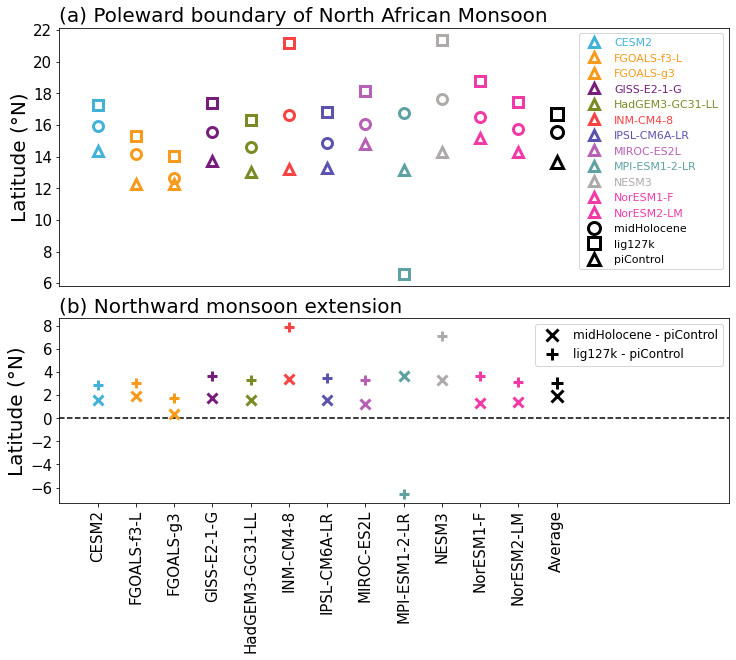

In [18]:
plt.figure(figsize=(12,10))
gs = gridspec.GridSpec(3, 1, height_ratios=[7,5,1]) 


plt.subplot(gs[0])
plt.title('(a) Poleward boundary of North African Monsoon',loc='left',fontsize=20)

position = 1
for m in available_model:
    plt.plot(position,mh_naf[m],marker='o',color=model_color(m,'py'),fillstyle='none',mew=3, ms=10,linestyle='None')
    plt.plot(position,lig_naf[m],marker='s',color=model_color(m,'py'),fillstyle='none',mew=3, ms=10,linestyle='None')
    plt.plot(position,pi_naf[m],marker='^',color=model_color(m,'py'),fillstyle='none',mew=3, ms=10,linestyle='None',label=m)
    position = position + 1
# ensemble average    
plt.plot(position,mh_naf_ave,marker='o',color='k',fillstyle='none',mew=3, ms=12,linestyle='None',label="midHolocene")
plt.plot(position,lig_naf_ave,marker='s',color='k',fillstyle='none',mew=3, ms=12,linestyle='None',label="lig127k")
plt.plot(position,pi_naf_ave,marker='^',color='k',fillstyle='none',mew=3, ms=12,linestyle='None',label="piControl")
leg=plt.legend(fontsize=11)
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
plt.xticks([])
plt.yticks(fontsize=15)
plt.ylabel('Latitude (%sN)'%chr(176),fontsize=20)
plt.xlim([0,position+4.5])

plt.subplot(gs[1])
plt.title('(b) Northward monsoon extension',loc='left',fontsize=20)
plt.axhline(y=0,color='k',linestyle="--")
#plt.axhline(xmin=0,xmax=20,y=10,color='k',linestyle="-",linewidth=1.5)

position1 = 1
for m in available_model:
    plt.plot(position1,diff_mh_naf[m],marker='x',color=model_color(m,'py'),fillstyle='none',mew=3, ms=10,linestyle='None')
    plt.plot(position1,diff_lig_naf[m],marker='+',color=model_color(m,'py'),fillstyle='none',mew=3, ms=10,linestyle='None')
    position1 = position1 + 1
    
plt.plot(position1,diff_mh_naf_ave,marker='x',color='k',fillstyle='none',mew=3, ms=12,linestyle='None',label="midHolocene - piControl")
plt.plot(position1,diff_lig_naf_ave,marker='+',color='k',fillstyle='none',mew=3, ms=12,linestyle='None',label="lig127k - piControl")
    
leg=plt.legend(fontsize=12)
plt.yticks(fontsize=15)
plt.ylabel('Latitude (%sN)'%chr(176),fontsize=20)
model_tick = available_model + ['Average']
number = np.linspace(1,position1,position1)
plt.xticks(number,model_tick,rotation=90,fontsize=15)
plt.xlim([0,position1+4.5])
plt.savefig('naf_expansion.pdf')

# Section 4: changes in regional monsoons

In [19]:
#Define monsoon names
monsoonlist=['NAMS','NAF','SAS','EAS','SAMS','SAF','AUSMC']
#NAMS:North American Monsoon System
#NAF: North Africa
#SAS Southern Asia 
#EAS: East Asia Summer 
#SAMS: South America Monsoon System
#SAF: Southern Asia
#AUSMC: Aurtralian-Maritime Continent

In [20]:
# this function collects the available monsoon data from csv files in data_frames
# var: rain (i.e. domain averaged rain rate) or area (i.e. domain area)
# kind: mean or stddev
def collect_monsoon_data(experiment_name,var,monsoon_name,kind):
    DATA = {}
    DATA['model'] = []
    DATA[experiment_name] = []
    DATA['piControl'] = []
    file_path = '../data_frames/monsoon_domains/'
    f = pd.read_csv('%s/monsoon_%s_%s_ANN_%s.csv'%(file_path,var,monsoon_name,kind),skipinitialspace=True,header=0)
    modellist = f['MODEL']
    for i,m in enumerate(modellist):
        if f[experiment_name][i] != -999 and f['piControl'][i] != -999:
            DATA['model'].append(m)
            DATA[experiment_name].append(f[experiment_name][i])
            DATA['piControl'].append(f['piControl'][i])
    return DATA

In [21]:
NAF_rain_mean = collect_monsoon_data('midHolocene','rain','NAF','mean')
NAF_rain_stddev = collect_monsoon_data('midHolocene','rain','NAF','stddev')
NAF_area_mean = collect_monsoon_data('midHolocene','area','NAF','mean')
NAF_area_stddev = collect_monsoon_data('midHolocene','area','NAF','stddev')

In [22]:
# compute cumulative water
NAF_totwater = {'model':[],'midHolocene':[],'piControl':[]}
for i,m1 in enumerate(NAF_rain_mean['model']):
    for j,m2 in enumerate(NAF_area_mean['model']):
        if m1 == m2:
            mhtotwater = NAF_rain_mean['midHolocene'][i] * NAF_area_mean['midHolocene'][j]
            pitotwater = NAF_rain_mean['piControl'][i] * NAF_area_mean['piControl'][j]
            NAF_totwater['model'].append(m1)
            NAF_totwater['midHolocene'].append(mhtotwater)
            NAF_totwater['piControl'].append(pitotwater)


In [23]:
# create available model list
pmip4_available_model = []
for model in pmip['PMIP4']:
    if model in NAF_rain_mean['model'] and model in NAF_rain_mean['model'] and model in NAF_area_mean['model'] and model in NAF_area_stddev['model']:
         pmip4_available_model.append(model)

pmip3_available_model = []
for model in pmip['PMIP3']:
    if model in NAF_rain_mean['model'] and model in NAF_rain_mean['model'] and model in NAF_area_mean['model'] and model in NAF_area_stddev['model']:
         pmip3_available_model.append(model)

In [11]:

pmip4_available_model

['CESM2',
 'EC-Earth3-LR',
 'FGOALS-f3-L',
 'FGOALS-g3',
 'GISS-E2-1-G',
 'INM-CM4-8',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM1-F',
 'NorESM2-LM',
 'UofT-CCSM-4']

In [12]:
pmip3_available_model

['CCSM4',
 'CNRM-CM5',
 'CSIRO-Mk3L-1-2',
 'CSIRO-Mk3-6-0',
 'EC-EARTH-2-2',
 'FGOALS-g2',
 'FGOALS-s2',
 'GISS-E2-R',
 'HadGEM2-CC',
 'HadGEM2-ES',
 'IPSL-CM5A-LR',
 'MIROC-ESM',
 'MPI-ESM-P',
 'MRI-CGCM3']

# compute % change in monsoon diagnostics
#### pav: change in area-averaged monsoon summer rain rate 
#### pad: change in the standard deviation of interannual variability in the area-averaged monsoon summer rain rate
#### aav: change in areal extent 
#### asd: change in the standard deviation of interannual variability in the areal extent 
#### totwater: change in cumulative rainfall, computed as pav x aav

In [24]:

def compute_monsoon_change(available_model,data):
    DATA = {}
    n = 0
    ave = 0
    for i,m in enumerate(data['model']):
        if m in available_model:
            mh_data = data['midHolocene'][i]           
            pi_data = data['piControl'][i]
            diff = (mh_data - pi_data) * 100 / pi_data
            DATA[m]=diff
            ave = (ave * n + diff) / (n + 1)
            n = n + 1
    return DATA,ave
            


In [25]:
pmip4_pav,pmip4_pav_ave = compute_monsoon_change(pmip4_available_model,NAF_rain_mean)
pmip4_psd,pmip4_psd_ave = compute_monsoon_change(pmip4_available_model,NAF_rain_stddev)
pmip4_aav,pmip4_aav_ave = compute_monsoon_change(pmip4_available_model,NAF_area_mean)
pmip4_asd,pmip4_asd_ave = compute_monsoon_change(pmip4_available_model,NAF_area_stddev)
pmip4_totwater,pmip4_totwater_ave = compute_monsoon_change(pmip4_available_model,NAF_totwater)

In [26]:
pmip3_pav,pmip3_pav_ave = compute_monsoon_change(pmip3_available_model,NAF_rain_mean)
pmip3_psd,pmip3_psd_ave = compute_monsoon_change(pmip3_available_model,NAF_rain_stddev)
pmip3_aav,pmip3_aav_ave = compute_monsoon_change(pmip3_available_model,NAF_area_mean)
pmip3_asd,pmip3_asd_ave = compute_monsoon_change(pmip3_available_model,NAF_area_stddev)
pmip3_totwater,pmip3_totwater_ave = compute_monsoon_change(pmip3_available_model,NAF_totwater)

In [21]:
# compute 




{'CESM2': 29.918049675327733,
 'EC-Earth3-LR': 40.097574104330775,
 'FGOALS-f3-L': 62.600327033259966,
 'FGOALS-g3': 37.00286911665877,
 'GISS-E2-1-G': 59.271432730338184,
 'INM-CM4-8': 71.61635438909632,
 'IPSL-CM6A-LR': 37.15046836783446,
 'MIROC-ES2L': 35.87292955820242,
 'MPI-ESM1-2-LR': 59.759618769701625,
 'MRI-ESM2-0': 36.29924729097212,
 'NESM3': 51.62546665743715,
 'NorESM1-F': 31.763828278687264,
 'NorESM2-LM': 22.839577059497252,
 'UofT-CCSM-4': 36.49289706157363}

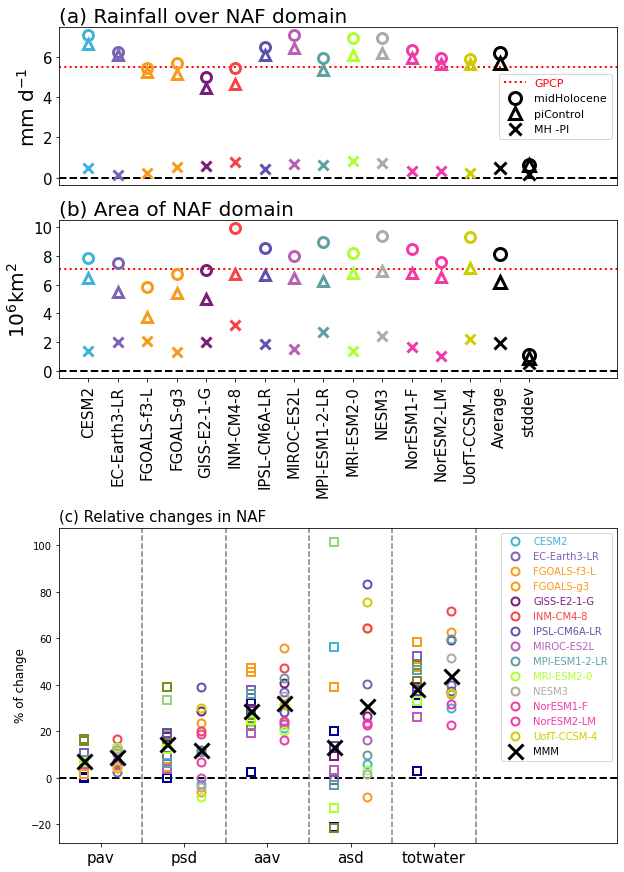

In [28]:

plt.figure(figsize=(10,15))
gs = gridspec.GridSpec(4,1,height_ratios=[2,2,1,4]) 

plt.subplot(gs[0])
plt.title('(a) Rainfall over NAF domain',loc='left',fontsize=20) 
plt.axhline(y=0,color='black',linestyle="--",linewidth=2)
plt.axhline(y=5.48,color='red',linestyle="dotted",linewidth=2,label='GPCP')#calculated from GPCP data
position = 1
pi_naf_rain = []
mh_naf_rain = []
d_naf_rain = []
for m in pmip4_available_model:
    for i,m1 in enumerate(NAF_rain_mean['model']):
        if m == m1:
            plt.plot(position,NAF_rain_mean['midHolocene'][i],marker='o',color=model_color(m,'py'),fillstyle='none',mew=3, ms=10,linestyle='None')
            plt.plot(position,NAF_rain_mean['piControl'][i],marker='^',color=model_color(m,'py'),fillstyle='none',mew=3, ms=10,linestyle='None')
            plt.plot(position,NAF_rain_mean['midHolocene'][i]-NAF_rain_mean['piControl'][i],marker='x',color=model_color(m,'py'),fillstyle='none',mew=3, ms=10,linestyle='None')
            position = position + 1
            d_naf_rain.append(NAF_rain_mean['midHolocene'][i]-NAF_rain_mean['piControl'][i])
            mh_naf_rain.append(NAF_rain_mean['midHolocene'][i])
            pi_naf_rain.append(NAF_rain_mean['piControl'][i])
        # ensemble average    
plt.plot(position,np.average(np.array(mh_naf_rain)),marker='o',color='k',fillstyle='none',mew=3, ms=12,linestyle='None',label="midHolocene")
plt.plot(position,np.average(np.array(pi_naf_rain)),marker='^',color='k',fillstyle='none',mew=3, ms=12,linestyle='None',label="piControl")
plt.plot(position,np.average(np.array(d_naf_rain)),marker='x',color='k',fillstyle='none',mew=3, ms=12,linestyle='None',label="MH -PI")
plt.plot(position+1,np.std(np.array(mh_naf_rain)),marker='o',color='k',fillstyle='none',mew=3, ms=12,linestyle='None')
plt.plot(position+1,np.std(np.array(pi_naf_rain)),marker='^',color='k',fillstyle='none',mew=3, ms=12,linestyle='None')
plt.plot(position+1,np.std(np.array(d_naf_rain)),marker='x',color='k',fillstyle='none',mew=3, ms=12,linestyle='None')
leg=plt.legend(fontsize=11)
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())

plt.xticks([])
plt.yticks(fontsize=15)
plt.ylabel('mm d$^{-1}$',fontsize=20)
plt.xlim([0,position+4])

plt.subplot(gs[1])
plt.title('(b) Area of NAF domain',loc='left',fontsize=20)
plt.axhline(y=0,color='black',linestyle="--",linewidth=2)
plt.axhline(y=7.06,color='red',linestyle="dotted",linewidth=2,label='GPCP')#calculated from GPCP data
position1 = 1
pi_naf_area = []
mh_naf_area = []
d_naf_area = []
for m in pmip4_available_model:
    for i,m1 in enumerate(NAF_area_mean['model']):
        if m == m1:
            plt.plot(position1,NAF_area_mean['midHolocene'][i]/10e5,marker='o',color=model_color(m,'py'),fillstyle='none',mew=3, ms=10,linestyle='None')
            plt.plot(position1,NAF_area_mean['piControl'][i]/10e5,marker='^',color=model_color(m,'py'),fillstyle='none',mew=3, ms=10,linestyle='None')
            plt.plot(position1,NAF_area_mean['midHolocene'][i]/10e5-NAF_area_mean['piControl'][i]/10e5,marker='x',color=model_color(m,'py'),fillstyle='none',mew=3, ms=10,linestyle='None')
            position1 = position1 + 1
            d_naf_area.append(NAF_area_mean['midHolocene'][i]/10e5-NAF_area_mean['piControl'][i]/10e5)
            mh_naf_area.append(NAF_area_mean['midHolocene'][i]/10e5)
            pi_naf_area.append(NAF_area_mean['piControl'][i]/10e5)
        # ensemble average    
plt.plot(position1,np.average(np.array(mh_naf_area)),marker='o',color='k',fillstyle='none',mew=3, ms=12,linestyle='None',label="midHolocene")
plt.plot(position1,np.average(np.array(pi_naf_area)),marker='^',color='k',fillstyle='none',mew=3, ms=12,linestyle='None',label="piControl")
plt.plot(position1,np.average(np.array(d_naf_area)),marker='x',color='k',fillstyle='none',mew=3, ms=12,linestyle='None',label="MH -PI")
plt.plot(position1+1,np.std(np.array(mh_naf_area)),marker='o',color='k',fillstyle='none',mew=3, ms=12,linestyle='None')
plt.plot(position1+1,np.std(np.array(pi_naf_area)),marker='^',color='k',fillstyle='none',mew=3, ms=12,linestyle='None')
plt.plot(position1+1,np.std(np.array(d_naf_area)),marker='x',color='k',fillstyle='none',mew=3, ms=12,linestyle='None')
model_tick = pmip4_available_model + ['Average','stddev']
number = np.linspace(1,position1+1,position1+1)
plt.xticks(number,model_tick,rotation=90,fontsize=15)
plt.xlim([0,position1+4])
plt.ylabel('10$^{6}$km$^{2}$',fontsize=20)
plt.yticks(fontsize=15)

plt.subplot(gs[3])
pos1=[0.3,1.3,2.3,3.3,4.3]
pos2=[0.7,1.7,2.7,3.7,4.7]
pos3=[0.5,1.5,2.5,3.5,4.5]
var_name=['pav','psd','aav','asd','totwater']
plt.title('(c) Relative changes in NAF',loc='left',fontsize=15)
plt.xlim([0,6.7])
lines=[1,2,3,4,5]
plt.axhline(y=0,color='black',linestyle="--",linewidth=2)
for l in lines:
    plt.axvline(l,color='grey',linestyle="--",linewidth=1.5)
    
    
for m in pmip3_available_model:
    plt.plot(pos1[0],pmip3_pav[m],marker='s',color=model_color(m,'py'),fillstyle='none',mew=2, ms=8,linestyle='None')
    plt.plot(pos1[1],pmip3_psd[m],marker='s',color=model_color(m,'py'),fillstyle='none',mew=2, ms=8,linestyle='None')
    plt.plot(pos1[2],pmip3_aav[m],marker='s',color=model_color(m,'py'),fillstyle='none',mew=2, ms=8,linestyle='None')
    plt.plot(pos1[3],pmip3_asd[m],marker='s',color=model_color(m,'py'),fillstyle='none',mew=2, ms=8,linestyle='None')
    plt.plot(pos1[4],pmip3_totwater[m],marker='s',color=model_color(m,'py'),fillstyle='none',mew=2, ms=8,linestyle='None')
plt.plot(pos1[0],pmip3_pav_ave,marker='x',color='k',fillstyle='none',mew=3, ms=15,linestyle='None')
plt.plot(pos1[1],pmip3_psd_ave,marker='x',color='k',fillstyle='none',mew=3, ms=15,linestyle='None')
plt.plot(pos1[2],pmip3_aav_ave,marker='x',color='k',fillstyle='none',mew=3, ms=15,linestyle='None')
plt.plot(pos1[3],pmip3_asd_ave,marker='x',color='k',fillstyle='none',mew=3, ms=15,linestyle='None')
plt.plot(pos1[4],pmip3_totwater_ave,marker='x',color='k',fillstyle='none',mew=3, ms=15,linestyle='None')


for m in pmip4_available_model:
    plt.plot(pos2[0],pmip4_pav[m],marker='o',color=model_color(m,'py'),fillstyle='none',mew=2, ms=8,linestyle='None',label=m)
    plt.plot(pos2[1],pmip4_psd[m],marker='o',color=model_color(m,'py'),fillstyle='none',mew=2, ms=8,linestyle='None')
    plt.plot(pos2[2],pmip4_aav[m],marker='o',color=model_color(m,'py'),fillstyle='none',mew=2, ms=8,linestyle='None')
    plt.plot(pos2[3],pmip4_asd[m],marker='o',color=model_color(m,'py'),fillstyle='none',mew=2, ms=8,linestyle='None')
    plt.plot(pos2[4],pmip4_totwater[m],marker='o',color=model_color(m,'py'),fillstyle='none',mew=2, ms=8,linestyle='None')
plt.plot(pos2[0],pmip4_pav_ave,marker='x',color='k',fillstyle='none',mew=3, ms=15,linestyle='None',label='MMM')
plt.plot(pos2[1],pmip4_psd_ave,marker='x',color='k',fillstyle='none',mew=3, ms=15,linestyle='None')
plt.plot(pos2[2],pmip4_aav_ave,marker='x',color='k',fillstyle='none',mew=3, ms=15,linestyle='None')
plt.plot(pos2[3],pmip4_asd_ave,marker='x',color='k',fillstyle='none',mew=3, ms=15,linestyle='None')
plt.plot(pos2[4],pmip4_totwater_ave,marker='x',color='k',fillstyle='none',mew=3, ms=15,linestyle='None')

plt.tick_params(labelsize=10)
plt.xticks(pos3,var_name,fontsize=15)
plt.ylabel('% of change',fontsize=12)
leg=plt.legend(loc='upper right',facecolor='white')
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
plt.savefig('naf.png')
plt.savefig('naf.pdf')